| [**Overview**](./00_overview.ipynb) | [Getting Started](./01_jupyter_python.ipynb) | **Examples:** | [Access](./02_accessing_indexing.ipynb) | [Transform](./03_transform.ipynb) | [Plotting](./04_simple_vis.ipynb) | [Norm-Spiders](./05_norm_spiders.ipynb) | [Minerals](./06_minerals.ipynb) |**Workflows:** | [lambdas](./07_lambdas.ipynb) | [CIPW](./08_CIPW_Norm.ipynb) | [ML](./11_geochem_ML.ipynb) | [Spatial Data](./12_spatial_geochem.ipynb) |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |

# lambdas: Paramaterising REE Profiles

Orthogonal polynomial decomposition can be used for dimensional reduction of smooth
function over an independent variable, producing an array of independent values
representing the relative weights for each order of component polynomial. This is an
effective method to parameterise and compare the nature of smooth profiles.

In geochemistry, the most applicable use case is for reduction Rare Earth Element (REE)
profiles. The REE are a collection of elements with broadly similar physicochemical
properties (the lanthanides), which vary with ionic radii. Given their similar behaviour
and typically smooth function of normalised abundance vs. ionic radii, the REE profiles
and their shapes can be effectively parameterised and dimensionally reduced (14 elements
summarised by 3-4 shape parameters).

Here we generate some example data, reduce these to lambda values, and visualise the
results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyrolite.plot

np.random.seed(82)

First we'll generate some example **synthetic data** based around Depleted MORB Mantle:

In [2]:
from pyrolite.util.synthetic import example_spider_data

df = example_spider_data(
    noise_level=0.1, size=100, start="DM_SS2004", offsets={"Eu": 0.2}, norm_to=None
).pyrochem.REE  # just take the REE data (we'll get a warning otherwise), start with unnormalised data!

In [3]:
df

,La,Ce,Pr,Nd,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu
0,0.259727,0.908303,0.150139,0.773598,0.289408,0.142218,0.422485,0.085400,0.622410,0.129849,0.432652,0.066162,0.478687,0.067947
1,0.224081,0.771516,0.140431,0.696586,0.264023,0.136116,0.412559,0.079719,0.541899,0.130533,0.387493,0.067373,0.391564,0.064062
2,0.254511,0.735317,0.128810,0.704559,0.261285,0.123705,0.388701,0.069947,0.541567,0.108802,0.334143,0.056112,0.381238,0.063145
3,0.191055,0.624804,0.107958,0.603416,0.233766,0.114518,0.294773,0.065048,0.444351,0.105335,0.354418,0.051111,0.320607,0.058868
4,0.255741,0.985616,0.160659,0.892812,0.310752,0.136968,0.463751,0.082247,0.567019,0.133385,0.455752,0.069911,0.458520,0.072302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.220890,0.806060,0.130334,0.768893,0.277940,0.132004,0.398334,0.075750,0.496484,0.132076,0.360365,0.057039,0.426867,0.066873
96,0.290455,0.925813,0.156256,0.971663,0.351170,0.152756,0.531034,0.098963,0.705867,0.155235,0.501587,0.077290,0.510231,0.083081
97,0.242283,0.755240,0.142031,0.800187,0.286715,0.134752,0.417609,0.069068,0.532903,0.122382,0.362930,0.061367,0.397654,0.062692
98,0.230126,0.751419,0.136239,0.709321,0.271665,0.119370,0.392559,0.073734,0.563749,0.131824,0.358053,0.066155,0.391128,0.065875


Let's have a quick look at what this REE data looks like normalized to Chondrite (in this case, the specific values used in the O'Neill 2016 paper):

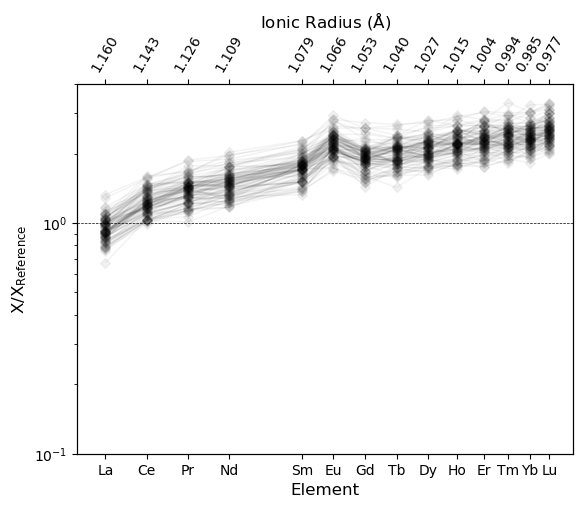

In [4]:
df.pyrochem.normalize_to("ChondriteREE_ON").pyroplot.REE(
    alpha=0.05, c="k", unity_line=True
)
plt.show()

From this REE data we can fit a series of orthogonal polynomials, and subsequently used
the regression coefficients ('lambdas') as a parameterisation of the REE
pattern/profile:




In [5]:
ls = df.pyrochem.lambda_lnREE(degree=4)
ls.head(2)

,λ0,λ1,λ2,λ3
0,0.709727,-4.596350,-14.489376,-168.290361
1,0.622747,-4.904404,-21.582010,-159.354541


So what's actually happening here? To get some idea of what these λ coefficients
correspond to, we can pull this process apart and visualise our REE profiles as
the sum of the series of orthogonal polynomial components of increasing order.
As lambdas represent the coefficients for the regression of log-transformed normalised
data, to compare the polynomial components and our REE profile we'll first need to
normalize it to the appropriate composition (here `"ChondriteREE_ON"`) before
taking the logarithm.

With our data, we've then fit a function of ionic radius with the form
$f(r) = \lambda_0 + \lambda_1 f_1 + \lambda_2 f_2 + \lambda_3 f_3...$
where the polynomial components of increasing order are $f_1 = (r - \beta_0)$,
$f_2 = (r - \gamma_0)(r - \gamma_1)$,
$f_3 = (r - \delta_0)(r - \delta_1)(r - \delta_2)$ and so on. The parameters
$\beta$, $\gamma$, $\delta$ are pre-computed such that the
polynomial components are indeed independent. Here we can visualise how these
polynomial components are summed to produce the regressed profile, using the last REE
profile we generated above as an example:




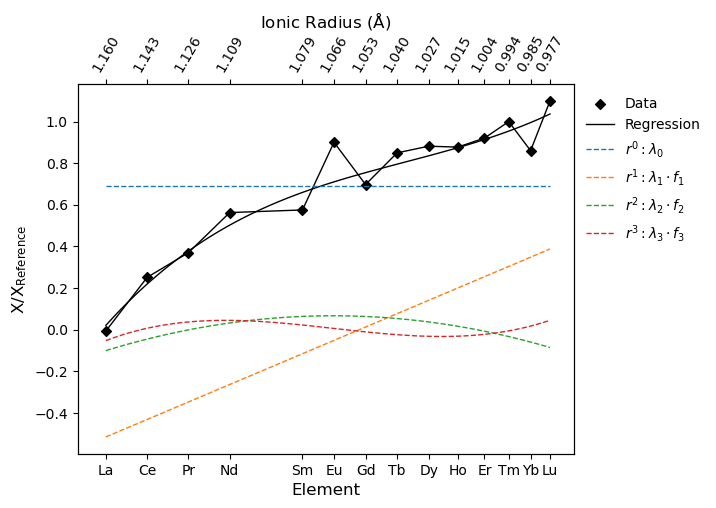

In [6]:
from pyrolite.util.lambdas.plot import plot_lambdas_components

ax = (
    df.pyrochem.normalize_to("ChondriteREE_ON")
    .iloc[-1, :]
    .apply(np.log)
    .pyroplot.REE(color="k", label="Data", logy=False, autoscale=False)
)

plot_lambdas_components(ls.iloc[-1, :], ax=ax)

ax.legend()

Now that we've gone through a brief introduction to how the lambdas are generated,
let's quickly check what the coefficient values themselves look like:




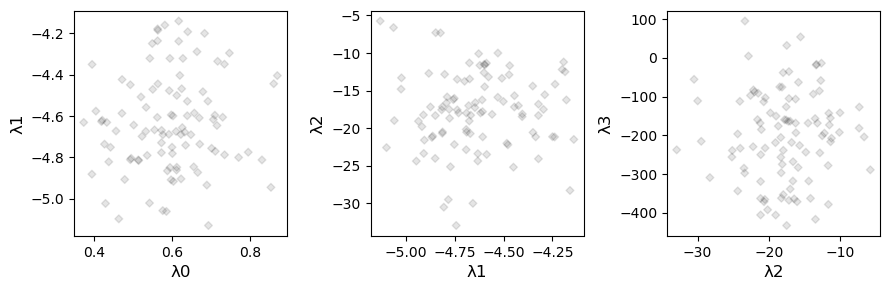

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for ix in range(ls.columns.size - 1):
    ls[ls.columns[ix : ix + 2]].pyroplot.scatter(ax=ax[ix], alpha=0.1, c="k")

plt.tight_layout()

But what do these parameters correspond to? From the deconstructed orthogonal
polynomial above, we can see that $\lambda_0$ parameterises relative enrichment
(this is the mean value of the logarithm of Chondrite-normalised REE abundances),
$\lambda_1$ parameterises a linear slope (here, LREE enrichment), and higher
order terms describe curvature of the REE pattern. Through this parameterisation,
the REE profile can be effectively described and directly linked to geochemical
processes. While the amount of data we need to describe the patterns is lessened,
the values themselves are more meaningful and readily used to describe the profiles
and their physical significance.

The visualisation of $\lambda_1$-$\lambda_2$ can be particularly useful
where you're trying to compare REE profiles.

We've used a synthetic dataset here which is by design approximately normally
distributed, so the values themeselves here are not particularly revealing,
but they do illustrate the expected mangitudes of values for each of the parameters.




----
<div class='alert alert-warning'> <font size="+1" color="black"><b> Checkpoint & Time Check</b><br>How are things going?</font></div>

----

## Dealing With Anomalies
Note that we've not used Eu in this regression - Eu anomalies are a deviation from
the 'smooth profile' we need to use this method. Consider this if your data might also
exhibit significant Ce anomalies, you might need to exclude this data. For convenience
there is also functionality to calculate anomalies derived from the orthogonal
polynomial fit itself (rather than linear interpolation methods). Below we use the
`anomalies` keyword argument to also calculate the $\frac{Ce}{Ce*}$
and $\frac{Eu}{Eu*}$ anomalies (note that these are excluded from the fit):

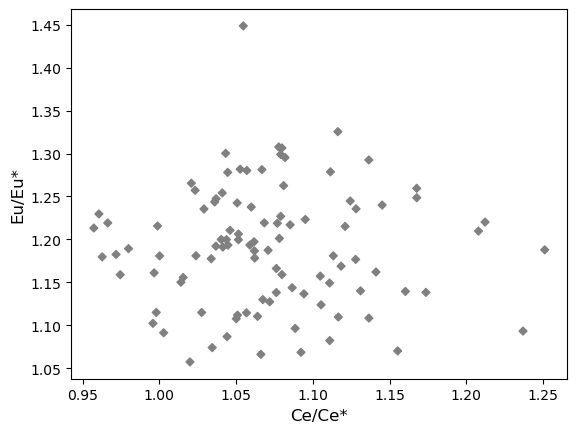

In [8]:
ls_anomalies = df.pyrochem.lambda_lnREE(anomalies=["Ce", "Eu"])
ax = ls_anomalies.iloc[:, -2:].pyroplot.scatter(color="0.5")

## Coefficient Uncertainties and Fit Quality

In order to determine the relative significance of the parameterisation and
'goodness of fit', the functions are able to estimate uncertainties on the returned
coefficients (lambdas and taus) and will also return the chi-square value
($\chi^2$; equivalent to the MSWD) where requested. This will be appended to the
end of the dataframe. Note that if you do not supply an estimate of observed value
uncertainties a default of 1% of the log-mean will be used.

To append the reduced chi-square for each row, the keyword argument
`add_X2=True` can be used; here we've estimated 5% uncertainty on the
REE.


In [9]:
ls = df.pyrochem.lambda_lnREE(add_X2=True, sigmas=0.05, anomalies=["Eu", "Ce"])
ls.columns

Index(['λ0', 'λ1', 'λ2', 'λ3', 'X2', 'Eu/Eu*', 'Ce/Ce*'], dtype='object')

We can have a quick look at the $\chi^2$ values look like for the synthetic
dataset, given the assumed 10% uncertainties. While the fit appears reasonable for a good
fraction of the dataset (~2 and below), for some rows it is notably worse:




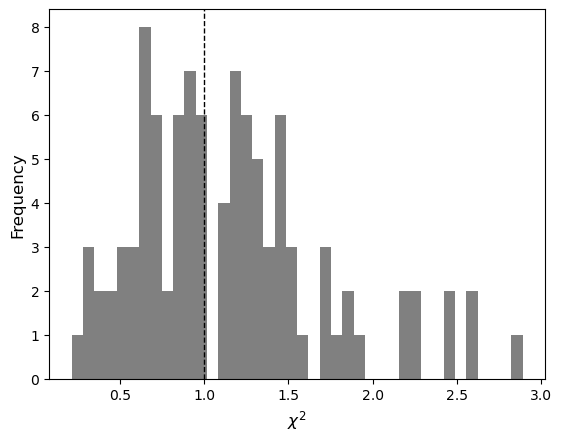

In [10]:
ax = ls["X2"].plot.hist(bins=40, color="0.5")
ax.set(xlabel="$\chi^2$")
ax.axvline(1, color="k", ls="--")
plt.show()

We can also examine the estimated uncertainties on the coefficients from the fit
by adding the keyword argument `add_uncertainties=True` (note: these do not
explicitly propagate observation uncertainties):

In [11]:
ls = df.pyrochem.lambda_lnREE(add_uncertainties=True)
ls.columns

Index(['λ0', 'λ1', 'λ2', 'λ3', 'λ0_σ', 'λ1_σ', 'λ2_σ', 'λ3_σ'], dtype='object')

We can have a look at what these uncertainties look like, noting that the principal differences between our samples are in λ0, as might be expected from how the random dataset is generated:

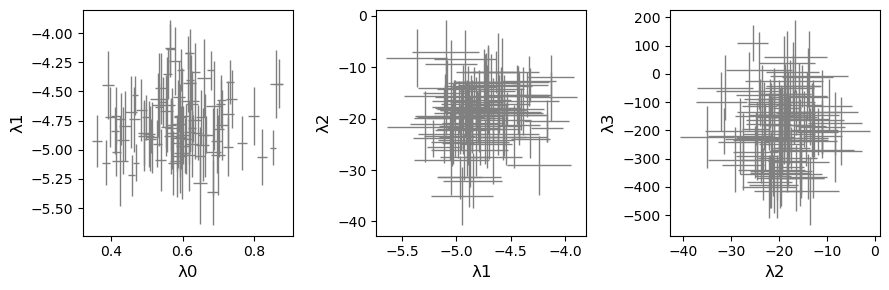

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax = ax.flat
dc = ls.columns.size // 2
for ix, a in enumerate(ls.columns[:3]):
    i0, i1 = ix, ix + 1
    ax[ix].set(xlabel=ls.columns[i0], ylabel=ls.columns[i1])
    ax[ix].errorbar(
        ls.iloc[:, i0],
        ls.iloc[:, i1],
        xerr=ls.iloc[:, i0 + dc],
        yerr=ls.iloc[:, i1 + dc],
        ls="none",
        ecolor="0.5",
        markersize=1,
        color="k",
    )
plt.tight_layout()
plt.show()

----
<div class='alert alert-warning'> <font size="+1" color="black"><b> Checkpoint & Time Check</b><br>How are things going?</font></div>

----

## Fitting Tetrads

In addition to fitting orothogonal polynomial functions, the ability to fit tetrad
functions has also recently been added. This supplements the $\lambda$
coefficients with $\tau$ coefficients which describe subtle electronic
configuration effects affecting sequential subsets of the REE. Below we plot four
profiles - each describing only a single tetrad - to illustrate the shape of
these function components. Note that these are functions of $z$, and are here
transformed to plot against radii.




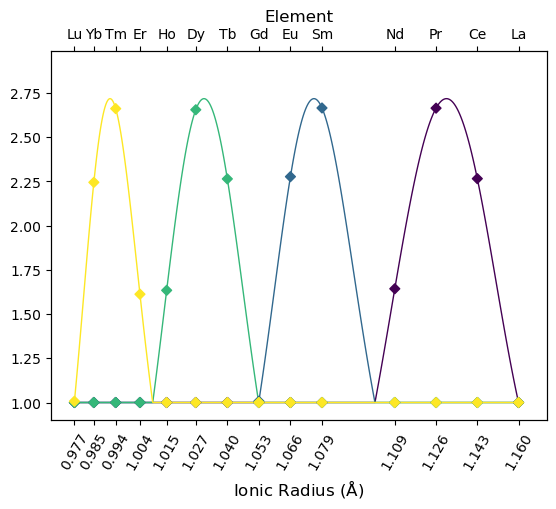

In [13]:
from pyrolite.util.lambdas.plot import plot_profiles

# let's first create some synthetic pattern parameters
# we want lambdas to be zero, and each of the tetrads to be shown in only one pattern
lambdas = np.zeros((4, 5))
tetrads = np.eye(4)
# putting it together to generate four sets of combined parameters
fit_parameters = np.hstack([lambdas, tetrads])

ax = plot_profiles(
    fit_parameters,
    tetrads=True,
    color=np.arange(4),
)
plt.show()

In order to also fit these function components, you can pass the keyword argument
`fit_tetrads=True` to `pyrolite.geochem.pyrochem.lambda_lnREE` and
related functions:




In [14]:
lts = df.pyrochem.lambda_lnREE(degree=4, fit_tetrads=True)

2024-11-11 18:06:17,584 pyrolite.util.lambdas - WARNING: Can't use the O'Neill (2016) algorithm to fit tetrads; falling back to the optimization based algorithm.


We can see that the four extra $\tau$ Parameters have been appended to the
right of the lambdas within the output:




In [15]:
lts.head(2)

,λ0,λ1,λ2,λ3,τ0,τ1,τ2,τ3
0,0.656232,-5.043367,-13.339143,-42.731108,0.146968,0.043607,0.060506,0.046370
1,0.588260,-5.947113,-22.040570,208.242364,0.254159,0.037333,-0.049228,-0.027386


| [**Overview**](./00_overview.ipynb) | [Getting Started](./01_jupyter_python.ipynb) | **Examples:** | [Access](./02_accessing_indexing.ipynb) | [Transform](./03_transform.ipynb) | [Plotting](./04_simple_vis.ipynb) | [Norm-Spiders](./05_norm_spiders.ipynb) | [Minerals](./06_minerals.ipynb) | **Workflows:** | [lambdas](./07_lambdas.ipynb) | [CIPW](./08_CIPW_Norm.ipynb)  | [ML](./11_geochem_ML.ipynb) | [Spatial Data](./12_spatial_geochem.ipynb) |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |